In [1]:
import pandas
import pylab
import numpy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, normalize
# import scipy
# import scipy.stats as stats
import seaborn

import matplotlib.pyplot as pyplot
import pylab
%matplotlib inline

from sklearn.datasets import load_iris

## Задачи исследования
1. Отличаются ли пелены от бинтов по параметрам?
2. Отличаются ли узкие, средние и широкие бинты друг от друга по параметрам?
3. Каков процент рогожки?
4. Какие группы тканей по качеству получаются?
5. Различаются ли нити основы и нити утка?
6. Какое количество (процент) тканей высокого качества имеют сбалансированное переплетение?
7. Какое количество (процент) тканей среднего качества имеет сбалансированное переплетение?
8. Какое количество (процент) тканей ниского качества имеет сбалансированное переплетение?
9. Каково соотношение сбалансированных тканей и тканей с преобладанием нитей основы?
10. Высчитать "коэффициент заполняемости" тканей
11. Разделить ткани по сбалансированности (сбалансированные - ±3 нити; ткани с преобладанием нитей основы); рассчитать процент каждой группы

### Список переменных
1. textiles - полный датафрейм, очищенный только от пропусков
2. textiles_cleared_thick - датафрейм, очищенный от выбросов по толщинам нитей
3. textiles_cleared_dens - датафрейм, очищенный от выбросов по плотностям тканей
4. textiles_cleared - датафрейм, очищенный от выбросов по плотностям тканей и толщинам нитей
5. outliers_thick - датафрейм выбросов по толщинам нитей
6. outliers_dens - датафрейм выбросов по плотности ткани
7. narrow_bands - датафрейм - только узкие бинты
8. middle_bands - датафрейм - только средние бинты
9. wide_bands - датафрейм - только широкие бинты
10. quartile_thick_warp_1 - первый квартиль по толщине по основе
11. quartile_thick_warp_2 - второй квартиль по толщине по основе
12. quartile_thick_warp_3 - третий квартиль по толщине по основе
13. quartile_thick_weft_1 - первый квартиль по толщине по утку
14. quartile_thick_weft_2 - второй квартиль по толщине по утку
15. quartile_thick_weft_3 - третий квартиль по толщине по утку
16. quartile_dens_warp_1 - первый квартиль по плотности по основе
17. quartile_dens_warp_2 - второй квартиль по плотности по основе
18. quartile_dens_warp_3 - третий квартиль по плотности по основе
19. quartile_dens_weft_1 - первый квартиль по плотности по утку
20. quartile_dens_weft_2 - второй квартиль по плотности по утку
21. quartile_dens_weft_3 - третий квартиль по плотности по утку

In [2]:
def convert_to_float(value):
    """
    Преобразование значений в столбцах датафрейма;
    :param value: float
    :return: float
    """
    value = str(value)
    value = value.replace(",", ".")
    value = round(float(value), 2)
    return value

#######################################################################################################################

# seaborn.set()
# seaborn.set_context("paper")


### Загрузка и предобработка данных



Общее количество записей - 303




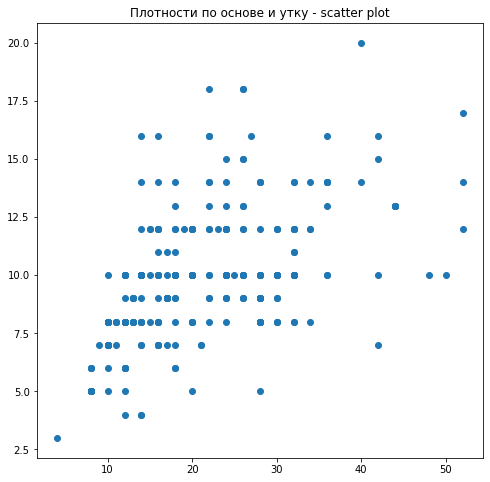

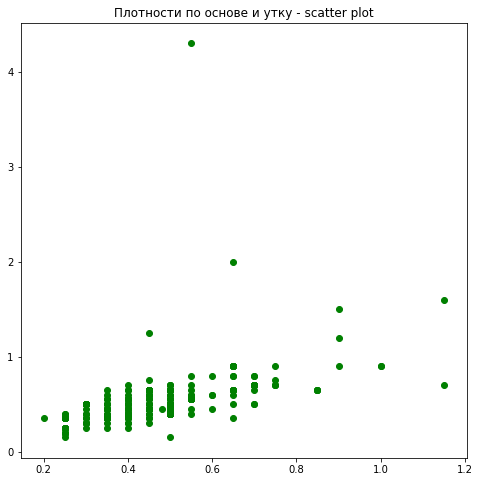

In [38]:
# Загрузка датафрейма из CSV файла;
textiles = pandas.read_csv('dataframe.csv')

len_textiles_base = len(textiles)
textiles = textiles.dropna(subset=['warp_dens', 'weft_dens'])
len_textiles = len(textiles)

########################################################################################################################

# Приведение типов колонок датафрейма к значению с плавающей запятой;
textiles['warp_a'] = textiles.warp_a.apply(convert_to_float)
textiles['warp_b'] = textiles.warp_b.apply(convert_to_float)
textiles['weft_a'] = textiles.weft_a.apply(convert_to_float)
textiles['weft_b'] = textiles.weft_b.apply(convert_to_float)

########################################################################################################################

# Вычисление "усредненных" толщин нитей;
textiles['warp_nominal'] = round((textiles['warp_a'] + textiles['warp_b']) / 2, 2)
textiles['weft_nominal'] = round((textiles['weft_a'] + textiles['weft_b']) / 2, 2)

########################################################################################################################

# Соотношение плотностей по основе и утку;
textiles['warp_weft'] = round((textiles['warp_dens'] / textiles['weft_dens']), 2)

########################################################################################################################

# Добавление признака density_coefficient;
textiles['density_coefficient'] = round((textiles['warp_dens'] / textiles['weft_dens']), 2)

########################################################################################################################

print()
# print(textiles.head())
print()
print("Общее количество записей - " + str(len_textiles), end="\n\n\n")

########################################################################################################################

fig, ax = pyplot.subplots(figsize=[8, 8])
pyplot.scatter(textiles['warp_dens'].tolist(), textiles['weft_dens'].tolist())
pyplot.title('Плотности по основе и утку - scatter plot')
pyplot.show()

print("\n\n")

########################################################################################################################

fig, ax = pyplot.subplots(figsize=[8, 8])
ax = pyplot.scatter(textiles['warp_nominal'].tolist(), textiles['weft_nominal'].tolist(), color='green')
pyplot.title('Плотности по основе и утку - scatter plot')
pyplot.show()

########################################################################################################################

### Вычисление квартилей

In [4]:
# Список получаемых переменных:
#
# quartile_thick_warp_1 - первый квартиль по толщине по основе
# quartile_thick_warp_2 - второй квартиль по толщине по основе
# quartile_thick_warp_3 - третий квартиль по толщине по основе
#
# quartile_thick_weft_1 - первый квартиль по толщине по утку
# quartile_thick_weft_2 - второй квартиль по толщине по утку
# quartile_thick_weft_3 - третий квартиль по толщине по утку
#
# quartile_dens_warp_1 - первый квартиль по плотности по основе
# quartile_dens_warp_2 - второй квартиль по плотности по основе
# quartile_dens_warp_3 - третий квартиль по плотности по основе
#
# quartile_dens_weft_1 - первый квартиль по плотности по утку
# quartile_dens_weft_2 - второй квартиль по плотности по утку
# quartile_dens_weft_3 - третий квартиль по плотности по утку


# квартили толщин нитей по основе;
quartile_thick_warp_1, quartile_thick_warp_2, quartile_thick_warp_3 = textiles['warp_nominal'].quantile([0.25, 0.5, 0.75])
quartile_thick_warp_1 = round(quartile_thick_warp_1, 2)
quartile_thick_warp_2 = round(quartile_thick_warp_2, 2)
quartile_thick_warp_3 = round(quartile_thick_warp_3, 2)

########################################################################################################################

# квартили толщин нитей по утку;
quartile_thick_weft_1, quartile_thick_weft_2, quartile_thick_weft_3 = textiles['weft_nominal'].quantile([0.25, 0.5, 0.75])
quartile_thick_weft_1 = round(quartile_thick_weft_1, 2)
quartile_thick_weft_2 = round(quartile_thick_weft_2, 2)
quartile_thick_weft_3 = round(quartile_thick_weft_3, 2)

########################################################################################################################

# квартили плотности по основе;
quartile_dens_warp_1, quartile_dens_warp_2, quartile_dens_warp_3 = textiles['warp_dens'].quantile([0.25, 0.5, 0.75])
quartile_dens_warp_1 = round(quartile_dens_warp_1, 2)
quartile_dens_warp_2 = round(quartile_dens_warp_2, 2)
quartile_dens_warp_3 = round(quartile_dens_warp_3, 2)

########################################################################################################################

# квартили плотности по утку;
quartile_dens_weft_1, quartile_dens_weft_2, quartile_dens_weft_3 = textiles['weft_dens'].quantile([0.25, 0.5, 0.75])
quartile_dens_weft_1 = round(quartile_dens_weft_1, 2)
quartile_dens_weft_2 = round(quartile_dens_weft_2, 2)
quartile_dens_weft_3 = round(quartile_dens_weft_3, 2)

########################################################################################################################

print()
print()
print("Квартили толщины по основе - " + 
      str(quartile_thick_warp_1) + ' ' + str(quartile_thick_warp_2) + ' ' + str(quartile_thick_warp_3))
print("Квартили толщины по утку - " + 
      str(quartile_thick_weft_1) + ' ' + str(quartile_thick_weft_2) + ' ' + str(quartile_thick_weft_3))
print("Квартили плотности по основе - " + 
      str(quartile_dens_warp_1) + ' ' + str(quartile_dens_warp_2) + ' ' + str(quartile_dens_warp_3))
print("Квартили плотности по утку - " + 
      str(quartile_dens_weft_1) + ' ' + str(quartile_dens_weft_2) + ' ' + str(quartile_dens_weft_3))




Квартили толщины по основе - 0.4 0.45 0.5
Квартили толщины по утку - 0.4 0.5 0.6
Квартили плотности по основе - 14.0 20.0 28.0
Квартили плотности по утку - 8.0 10.0 12.0


### Описание полного набора данных

In [5]:
textiles_warp_thick_mean = round(textiles['warp_nominal'].mean(), 3)
textiles_warp_thick_median = round(textiles['warp_nominal'].median(), 3)
textiles_weft_thick_mean = round(textiles['weft_nominal'].mean(), 3)
textiles_weft_thick_median = round(textiles['weft_nominal'].median(), 3)

########################################################################################################################

print()
print("Толщина по основе - среднее значение - " + str(textiles_warp_thick_mean))
print("Толщина по основе - медиана - " + str(textiles_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(textiles_weft_thick_mean))
print("Толщина по утку - медиана - " + str(textiles_weft_thick_median))

########################################################################################################################

textiles_warp_dens_mean = round(textiles['warp_dens'].mean(), 3)
textiles_warp_dens_median = round(textiles['warp_dens'].median(), 3)
textiles_weft_dens_mean = round(textiles['weft_dens'].mean(), 3)
textiles_weft_dens_median = round(textiles['weft_dens'].median(), 3)

########################################################################################################################

print()
print("Плотность по основе - среднее значение - " + str(textiles_warp_dens_mean))
print("Плотность по основе - медиана - " + str(textiles_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(textiles_weft_dens_mean))
print("Плотность по утку - медиана - " + str(textiles_weft_dens_median))


Толщина по основе - среднее значение - 0.471
Толщина по основе - медиана - 0.45
Толщина по утку - среднее значение - 0.53
Толщина по утку - медиана - 0.5

Плотность по основе - среднее значение - 21.231
Плотность по основе - медиана - 20.0
Плотность по утку - среднее значение - 9.851
Плотность по утку - медиана - 10.0


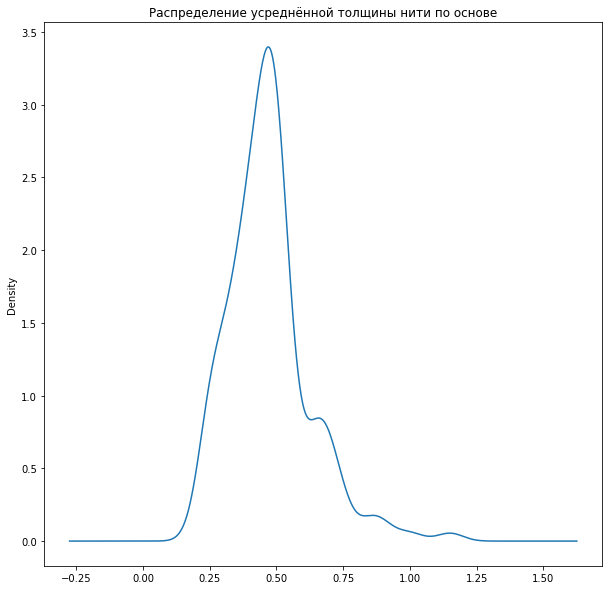

In [47]:
warp_thick = textiles['warp_nominal']
warp_thick.plot.kde(title='Распределение усреднённой толщины нити по основе', figsize=[10, 10])

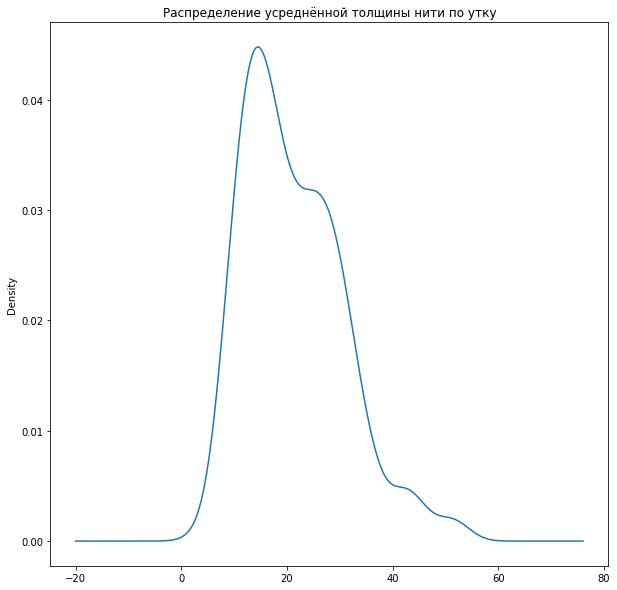

In [48]:
warp_density = textiles['warp_dens']
warp_density.plot.kde(title='Распределение усреднённой толщины нити по утку', figsize=[10, 10])

In [9]:
# seaborn.heatmap(textiles[['warp_nominal', 'weft_nominal', 'warp_dens', 'weft_dens']].corr(), square=True, annot=True)

### Вычисление "выбросов" в данных

In [10]:
# Описание получаемых переменных:
#
# textiles_cleared_thick - датафрейм, очищенный от выбросов по толщине
# textiles_cleared_dens - датафрейм, очищенный от выбросов по плотности


# Выбросы по толщинам нитей по основе;
textiles_cleared_thick = \
    textiles[textiles.warp_nominal < 
             (quartile_thick_warp_3 + 1.5 * (quartile_thick_warp_3 + quartile_thick_warp_1))]
textiles_cleared_thick = \
    textiles_cleared_thick[textiles_cleared_thick.warp_nominal > 
                     (quartile_thick_warp_1 - 1.5 * (quartile_thick_warp_3 - quartile_thick_warp_1))]

########################################################################################################################

# Выбросы по плотности ткани по основе;
textiles_cleared_dens = \
    textiles[textiles.warp_dens <
             (quartile_dens_warp_1 + 1.5 * (quartile_dens_warp_3 - quartile_dens_warp_1))]

textiles_cleared_dens = \
    textiles_cleared_dens[textiles_cleared_dens.warp_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared_dens = \
    textiles_cleared_dens[textiles_cleared_dens.weft_dens <
                          (quartile_dens_weft_1 + 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared_dens = \
    textiles_cleared_dens[textiles_cleared_dens.weft_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

########################################################################################################################

textiles_cleared = \
    textiles[textiles.warp_nominal < 
             (quartile_thick_warp_3 + 1.5 * (quartile_thick_warp_3 + quartile_thick_warp_1))]
textiles_cleared = \
    textiles_cleared[textiles_cleared.warp_nominal > 
                     (quartile_thick_warp_1 - 1.5 * (quartile_thick_warp_3 - quartile_thick_warp_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.warp_dens <
             (quartile_dens_warp_1 + 1.5 * (quartile_dens_warp_3 - quartile_dens_warp_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.warp_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.weft_dens <
                          (quartile_dens_weft_1 + 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.weft_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

########################################################################################################################

# Датафрейм - только выбросы по толщинам нитей по основе;
outliers_thick = textiles[~textiles.index.isin(textiles_cleared_thick.index)]
outliers_dens = textiles[~textiles.index.isin(textiles_cleared_dens.index)]

########################################################################################################################

print()
print("Выбросов по толщине нити - " + str(len(outliers_thick)))
print("Выбросов по плотности тканей - " + str(len(outliers_dens)))
print("Размерность набора данных без учета выбросов - " + str(len(textiles_cleared)))
print()
print()



Выбросов по толщине нити - 26
Выбросов по плотности тканей - 47
Размерность набора данных без учета выбросов - 245




In [11]:
# warp_thick_outliers = outliers_thick['warp_nominal']
# warp_thick_outliers.plot.kde()

In [13]:
# warp_dens_outliers = outliers_thick['warp_dens']
# warp_dens_outliers.plot.kde()

### Иерархическая кластеризация

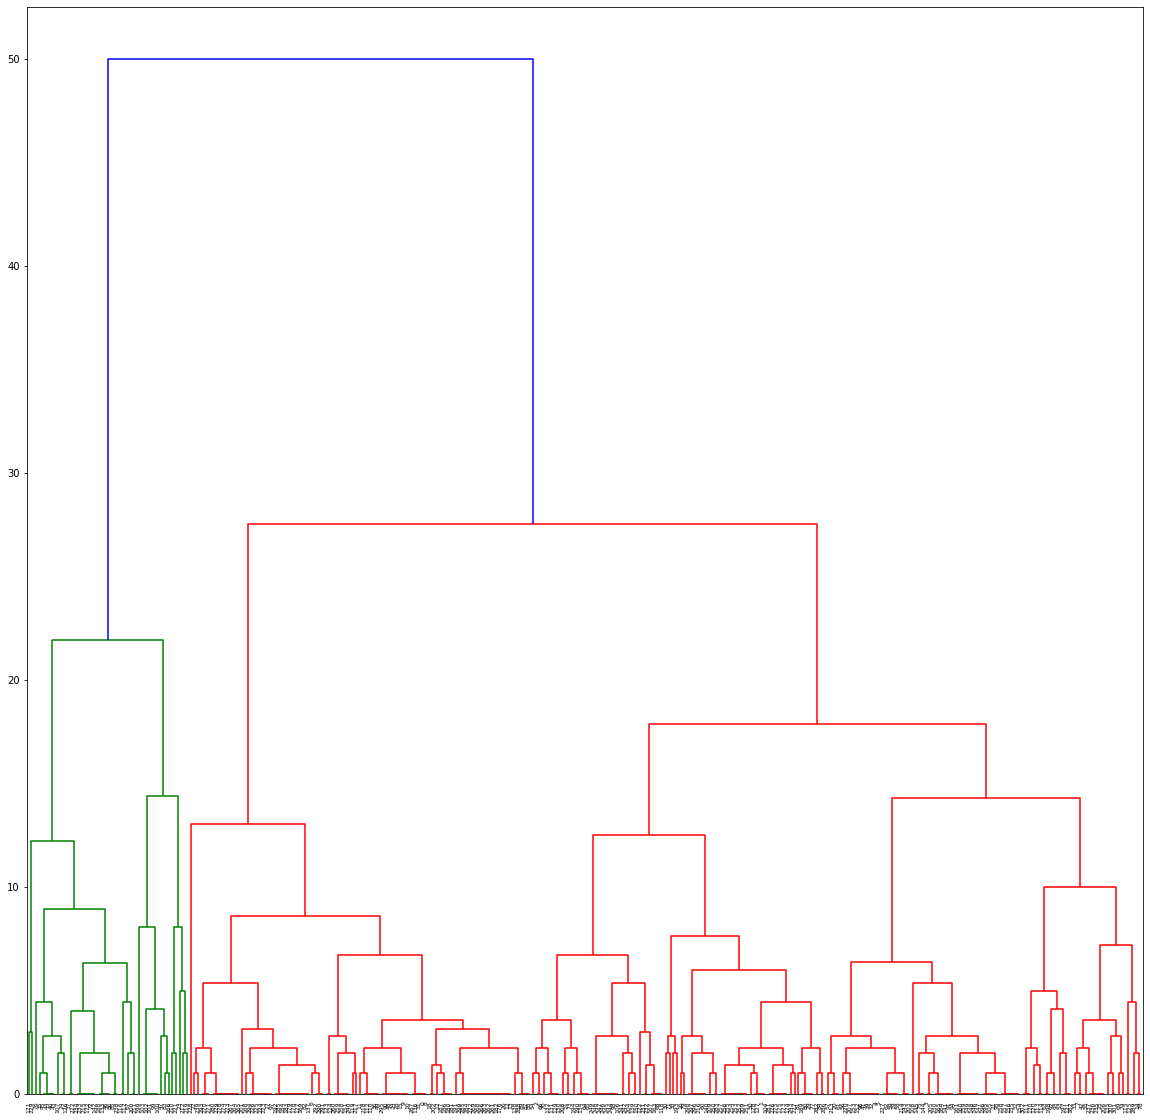

[[  0.           8.           0.           2.        ]
 [  1.         104.           0.           2.        ]
 [  2.          66.           0.           2.        ]
 ...
 [596.         600.          21.9317122   44.        ]
 [598.         601.          27.51363298 259.        ]
 [602.         603.          50.         303.        ]]


In [40]:
dens_warp_list = textiles['warp_dens'].tolist()
dens_weft_list = textiles['weft_dens'].tolist()

thick_warp_nominal_list = textiles['warp_nominal'].tolist()
thick_weft_nominal_list = textiles['weft_nominal'].tolist()

warp_weft_dens_list = []
for index, item in enumerate(dens_warp_list):\
    warp_weft_dens_list.append((dens_warp_list[index], dens_weft_list[index]))

mergings = linkage(warp_weft_dens_list, method='complete')
fig, ax = pyplot.subplots(figsize=[20, 20])
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6, ax=ax)
pyplot.show()
print(mergings)

### Кластеризация

In [50]:

########################################################################################################################

# Список кортежей для полной выборки

dens_warp_list = textiles['warp_dens'].tolist()
dens_weft_list = textiles['weft_dens'].tolist()

thick_warp_nominal_list = textiles['warp_nominal'].tolist()
thick_weft_nominal_list = textiles['weft_nominal'].tolist()

warp_weft_dens_list = []
for index, item in enumerate(dens_warp_list):\
    warp_weft_dens_list.append((dens_warp_list[index], dens_weft_list[index]))
    
print('\nРазмерность полученного списка - (полная выборка)' + str(len(warp_weft_dens_list)), end='\n')

########################################################################################################################

numeric_values_list = []

for index, _ in enumerate(dens_warp_list):
    numeric_values_list.append(
        [dens_warp_list[index], dens_weft_list[index], thick_warp_nominal_list[index], thick_weft_nominal_list[index]]
    )

########################################################################################################################

# Кластеризация с помощью K-Means - полная выборка

kmeans = KMeans(n_clusters=3)

kmeans.fit(warp_weft_dens_list)
predictions = kmeans.predict(warp_weft_dens_list)
print("Полученные номера кластеров (k-means, полная выборка) - \n" + str(predictions), end="\n\n\n")

########################################################################################################################

# Список кортежей для выборки, очищенной от выбросов

dens_warp_list_cleared = textiles_cleared['warp_dens'].tolist()
dens_weft_list_cleared = textiles_cleared['weft_dens'].tolist()

thick_warp_nominal_list = textiles['warp_nominal'].tolist()
thick_weft_nominal_list = textiles['weft_nominal'].tolist()

numeric_values_cleared = []
for index, _ in enumerate(numeric_values_cleared):
    numeric_values_cleared.append((dens_warp_list_cleared[index], dens_weft_list_cleared[index], thick_warp_nominal_list[index], thick_weft_nominal_list[index]))
    
print('\nРазмерность полученного списка - (выборка без выбросов)' + str(len(numeric_values_cleared)), end='\n\n\n')

# Кластеризация с помощью K-Means - выборка, очищенная от выбросов

kmeans_cleared = KMeans(n_clusters=3)

kmeans_cleared.fit(numeric_values_cleared)
predictions_cleared = kmeans_cleared.predict(numeric_values_cleared)
print("Полученные номера кластеров (k-means, без выбросов по плотности ткани) - \n" + str(predictions_cleared), end="\n\n\n")

########################################################################################################################

kmeans_numeric = KMeans(n_clusters=3)

kmeans_numeric.fit(numeric_values_list)
predictions_numeric = kmeans_numeric.predict(numeric_values_list)
print("Полученные номера кластеров (k-means, все числовые признаки) - \n" + str(predictions_numeric), end="\n\n\n")

########################################################################################################################

# Основной датафрейм - колонка с полученными номерами кластеров
textiles['kmeans_dens'] = predictions
textiles['kmeans_numeric'] = predictions_numeric
# textiles_cleared['kmeans_dens'] = predictions_cleared

########################################################################################################################

# График - отображение полученных кластеров

print("\nПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)\n")

_, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[16, 8])
axes[0].scatter(textiles.query('kmeans_numeric == 0')['warp_dens'].tolist(),
                         textiles.query('kmeans_numeric == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes[0].scatter(textiles.query('kmeans_numeric == 1')['warp_dens'].tolist(),
                         textiles.query('kmeans_numeric == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes[0].scatter(textiles.query('kmeans_numeric == 2')['warp_dens'].tolist(),
                         textiles.query('kmeans_numeric == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes[0].set_title("Распределение плотностей тканей")
axes[0].legend()
axes[1].scatter(textiles.query('kmeans_numeric == 0')['warp_nominal'].tolist(),
                         textiles.query('kmeans_numeric == 0')['weft_nominal'].tolist(), marker='*', label="cluster 1")
axes[1].scatter(textiles.query('kmeans_numeric == 1')['warp_nominal'].tolist(),
                         textiles.query('kmeans_numeric == 1')['weft_nominal'].tolist(), marker='+', label="cluster 2")
axes[1].scatter(textiles.query('kmeans_numeric == 2')['warp_nominal'].tolist(),
                         textiles.query('kmeans_numeric == 2')['weft_nominal'].tolist(), marker='o', label="cluster 3")
axes[1].set_title("Распределение толщин нитей")
axes[1].legend()
pyplot.show()


print("\n\nДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ\n")
_, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[16, 8])
axes[0].scatter(textiles_cleared.query('kmeans_numeric == 0')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_numeric == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes[0].scatter(textiles_cleared.query('kmeans_numeric == 1')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_numeric == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes[0].scatter(textiles_cleared.query('kmeans_numeric == 2')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_numeric == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes[0].legend()
axes[1].scatter(textiles_cleared.query('kmeans_numeric == 0')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_numeric == 0')['weft_nominal'].tolist(), marker='*', label="cluster 1")
axes[1].scatter(textiles_cleared.query('kmeans_numeric == 1')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_numeric == 1')['weft_nominal'].tolist(), marker='+', label="cluster 2")
axes[1].scatter(textiles_cleared.query('kmeans_numeric == 2')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_numeric == 2')['weft_nominal'].tolist(), marker='o', label="cluster 3")
axes[1].legend()
pyplot.show()



Размерность полученного списка - (полная выборка)303
Полученные номера кластеров (k-means, полная выборка) - 
[1 1 1 2 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 2 2 1 0 2 2 1 1 1 1 1 1 2 2 1 0 1
 2 1 2 0 2 2 0 0 0 2 0 1 1 1 1 2 2 1 2 2 2 2 2 1 2 2 2 1 1 1 2 1 2 1 1 2 1
 2 2 0 1 2 1 1 1 1 0 1 2 2 1 1 1 1 2 2 2 2 2 2 1 1 0 0 0 0 0 1 2 1 2 2 1 1
 2 1 2 2 2 0 0 1 1 2 2 1 1 1 2 2 1 1 1 1 1 1 2 1 2 1 1 1 2 1 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 1 1 1 2 0 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 2 2 2 2 0 2 1 1 2 2 2 2 2 1 1 0 2 0 2 2 2 1 1 1 0 2 0
 2 1 1 1 1 2 1 0 2 1 1 2 2 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 2 2 2]



Размерность полученного списка - (выборка без выбросов)0




ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### #1 Отличаются ли пелены от бинтов по параметрам?
### #2 Отличаются ли узкие, средние и широкие бинты

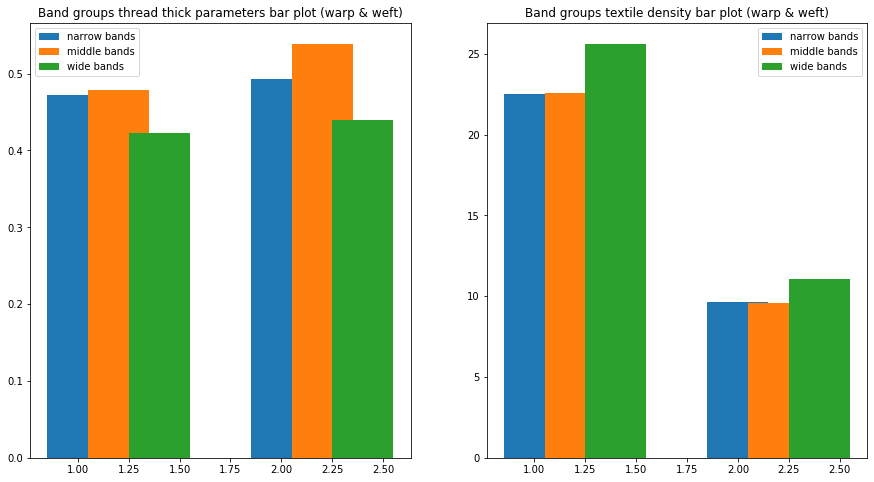


Узких бинтов - 94
Средних бинтов - 81
Широких бинтов - 19
Всего бинтов - 194

Процент узких бинтов (от общего количества тканей) - 31.02
Процент средних бинтов (от общего количества тканей) - 26.73
Процент широких бинтов ( от общего количества тканей) - 6.27

Процент узких бинтов (от общего количества бинтов) - 48.45
Процент средних бинтов (от общего количества бинтов) - 41.75
Процент щироких бинтов (от общего количества бинтов) - 9.79

Процент бинтов (от общего количества тканей) - 64.03

Узкие бинты:
Толщина по основе - среднее значение - 0.472
Толщина по основе - медиана - 0.45
Толщина по утку - среднее значение - 0.493
Толщина по утку - медиана - 0.5

Плотность по основе - среднее значение - 22.532
Плотность по основе - медиана - 22.0
Плотность по утку - среднее значение - 9.617
Плотность по утку - медиана - 9.0

Средние бинты:
Толщина по основе - среднее значение - 0.479
Толщина по основе - медиана - 0.45
Толщина по утку - среднее значение - 0.539
Толщина по утку - медиана - 0.5


In [22]:
# датафрейм - только узкие бинты;
narrow_bands = textiles[textiles['type'] == 'n_band']
# датафрейм - только средние бинты;
middle_bands = textiles[textiles['type'] == 'm_band']
# датафрейм - только широкие бинты;
wide_bands = textiles[textiles['type'] == 'w_band']

# датафрейм - бинты всех типов;
bands = pandas.concat([narrow_bands, middle_bands, wide_bands])

########################################################################################################################

# процент узких бинтов - от общего количества тканей;
narrow_bands_percent_textiles = round((len(narrow_bands) / len(textiles)) * 100, 2)
# процент средних ьинтов - от общего количества тканей;
middle_bands_percent_textiles = round((len(middle_bands) / len(textiles)) * 100, 2)
# процент широких бинтов - от общего количества тканей;
wide_bands_percent_textiles = round((len(wide_bands) / len(textiles)) * 100, 2)
# процент всех бинтов - от общего количества тканей;
bands_percent = round((len(bands) / len(textiles)) * 100, 2)

########################################################################################################################

narrow_bands_percent_bands = round((len(narrow_bands) / len(bands)) * 100, 2)
middle_bands_percent_bands = round((len(middle_bands) / len(bands)) * 100, 2)
wide_bands_percent_bands = round((len(wide_bands) / len(bands)) * 100, 2)

########################################################################################################################

# Толщина нитей и плотность тканей - медиана и среднее -  для узких бинтов

nbands_warp_thick_mean = round(narrow_bands['warp_nominal'].mean(), 3)
nbands_warp_thick_median = round(narrow_bands['warp_nominal'].median(), 3)
nbands_weft_thick_mean = round(narrow_bands['weft_nominal'].mean(), 3)
nbands_weft_thick_median = round(narrow_bands['weft_nominal'].median(), 3)
nbands_warp_dens_mean = round(narrow_bands['warp_dens'].mean(), 3)
nbands_warp_dens_median = round(narrow_bands['warp_dens'].median(), 3)
nbands_weft_dens_mean = round(narrow_bands['weft_dens'].mean(), 3)
nbands_weft_dens_median = round(narrow_bands['weft_dens'].median(), 3)

########################################################################################################################

# Толщина нитей и плотность тканей - медиана и среднее -  для средних бинтов

mbands_warp_thick_mean = round(middle_bands['warp_nominal'].mean(), 3)
mbands_warp_thick_median = round(middle_bands['warp_nominal'].median(), 3)
mbands_weft_thick_mean = round(middle_bands['weft_nominal'].mean(), 3)
mbands_weft_thick_median = round(middle_bands['weft_nominal'].median(), 3)
mbands_warp_dens_mean = round(middle_bands['warp_dens'].mean(), 3)
mbands_warp_dens_median = round(middle_bands['warp_dens'].median(), 3)
mbands_weft_dens_mean = round(middle_bands['weft_dens'].mean(), 3)
mbands_weft_dens_median = round(middle_bands['weft_dens'].median(), 3)

########################################################################################################################

# Толщина нитей и плотность тканей - медиана и среднее -  для широкий бинтов

wbands_warp_thick_mean = round(wide_bands['warp_nominal'].mean(), 3)
wbands_warp_thick_median = round(wide_bands['warp_nominal'].median(), 3)
wbands_weft_thick_mean = round(wide_bands['weft_nominal'].mean(), 3)
wbands_weft_thick_median = round(wide_bands['weft_nominal'].median(), 3)
wbands_warp_dens_mean = round(wide_bands['warp_dens'].mean(), 3)
wbands_warp_dens_median = round(wide_bands['warp_dens'].median(), 3)
wbands_weft_dens_mean = round(wide_bands['weft_dens'].mean(), 3)
wbands_weft_dens_median = round(wide_bands['weft_dens'].median(), 3)

########################################################################################################################

# Парный график - толщины нитей и плотности тканей для групп бинтов

ax, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[15, 8])
axes[0].set_title('Band groups thread thick parameters bar plot (warp & weft)')
axes[0].bar((1, 2), (nbands_warp_thick_mean, nbands_weft_thick_mean), width=0.3, label='narrow bands')
axes[0].bar((1.2, 2.2), (mbands_warp_thick_mean, mbands_weft_thick_mean), width=0.3, label='middle bands')
axes[0].bar((1.4, 2.4), (wbands_warp_thick_mean, wbands_weft_thick_mean), width=0.3, label='wide bands')
axes[0].legend()
axes[1].set_title('Band groups textile density bar plot (warp & weft)')
axes[1].bar((1, 2), (nbands_warp_dens_mean, nbands_weft_dens_mean), width=0.3, label='narrow bands')
axes[1].bar((1.2, 2.2), (mbands_warp_dens_mean, mbands_weft_dens_mean), width=0.3, label='middle bands')
axes[1].bar((1.4, 2.4), (wbands_warp_dens_mean, wbands_weft_dens_mean), width=0.3, label='wide bands')
axes[1].legend()
print()
print()
pyplot.show()

########################################################################################################################

# Вывод текстовой информации

print()
print("Узких бинтов - " + str(len(narrow_bands)))
print("Средних бинтов - " + str(len(middle_bands)))
print("Широких бинтов - " + str(len(wide_bands)))
print("Всего бинтов - " + str(len(bands)))
print()

print("Процент узких бинтов (от общего количества тканей) - " + str(narrow_bands_percent_textiles))
print("Процент средних бинтов (от общего количества тканей) - " + str(middle_bands_percent_textiles))
print("Процент широких бинтов ( от общего количества тканей) - " + str(wide_bands_percent_textiles))

print()
print("Процент узких бинтов (от общего количества бинтов) - " + str(narrow_bands_percent_bands))
print("Процент средних бинтов (от общего количества бинтов) - " + str(middle_bands_percent_bands))
print("Процент щироких бинтов (от общего количества бинтов) - " + str(wide_bands_percent_bands))

print()
print("Процент бинтов (от общего количества тканей) - " + str(bands_percent))

print()
print("Узкие бинты:")
print("Толщина по основе - среднее значение - " + str(nbands_warp_thick_mean))
print('Толщина по основе - медиана - ' + str(nbands_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(nbands_weft_thick_mean))
print("Толщина по утку - медиана - " + str(nbands_weft_thick_median))
print()
print("Плотность по основе - среднее значение - " + str(nbands_warp_dens_mean))
print("Плотность по основе - медиана - " + str(nbands_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(nbands_weft_dens_mean))
print("Плотность по утку - медиана - " + str(nbands_weft_dens_median))

print()
print("Средние бинты:")
print("Толщина по основе - среднее значение - " + str(mbands_warp_thick_mean))
print("Толщина по основе - медиана - " + str(mbands_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(mbands_weft_thick_mean))
print("Толщина по утку - медиана - " + str(mbands_weft_thick_median))
print()
print("Плотность по основе - среднее значение - " + str(mbands_warp_dens_mean))
print("Плотность по основе - медиана - " + str(mbands_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(mbands_weft_dens_mean))
print("Плотность по утку - медиана - " + str(mbands_weft_dens_median))

print()
print("Широкие бинты:")
print("Толщина по основе - среднее значение - " + str(wbands_warp_thick_mean))
print("Толщина по основе - медиана - " + str(wbands_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(wbands_weft_thick_mean))
print("Толщина по утку - медиана - " + str(wbands_weft_thick_median))
print()
print("Плотность по основе - среднее значение - " + str(wbands_warp_dens_mean))
print("Плотность по основе - медиана - " + str(wbands_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(wbands_weft_dens_mean))
print("Плотность по утку - медиана - " + str(wbands_weft_dens_median))

### #3 Каков процент рогожки?

### #4 Какие группы тканей по качеству получаются?

#### #4.1 Ткани с высокой плотностью по основе

##### #4.1.1 Проверка тенденции к сбалансированности у тканей с высокой плотностью по основе

In [23]:

########################################################################################################################

def proportion(x, y):
    return round(x / y, 2)

########################################################################################################################

high_density_warp = textiles.query("warp_dens >= 20").copy()
high_density_warp['warp_weft'] = high_density_warp.apply(lambda x: proportion(x['warp_dens'], x['weft_dens']), axis = 1)
print("Всего тканей с высокой плотностью по основе (более или равно 20) - " + str(len(high_density_warp)))
# high_density_warp['warp_weft'].plot.hist(color='green', alpha=0.5,
#                                          title='Гистограмма соотношений плотностей по основе и утку для'
#                                                ' тканей с высокой плотностью по основе', figsize=[8, 8], bins=30)

########################################################################################################################


Всего тканей с высокой плотностью по основе (более или равно 20) - 156


In [ ]:
# high_density_warp['warp_weft'].plot.kde(color='red', figsize=[8, 8],
# title='warp/weft для тканей с высокой плотностью по основе')

##### #4.1.2 Проверка тенденции к сбалансированности у тканей с умеренной плотностью по основе

In [24]:
low_density_warp = textiles.query("warp_dens < 20").copy()
low_density_warp['warp_weft'] = low_density_warp.apply(lambda x: proportion(x['warp_dens'], x['weft_dens']), axis = 1)
print("Всего тканей с низкой и умеренной плотностью по основе (менее 20) - " + str(len(low_density_warp)))
# low_density_warp['warp_weft'].plot.hist(color='green', alpha=0.5, title='',figsize=[8, 8], bins=30)

Всего тканей с низкой и умеренной плотностью по основе (менее 20) - 147


In [25]:
# low_density_warp['warp_weft'].plot.kde(color='red', figsize=[8, 8],
# title='warp/weft для тканей с низкой плотностью по основе')

### #5 Различаются ли нити основы и нити утка?

### #11 Разделить ткани по сбалансированности (сбалансированные - ±3 нити; ткани с преобладанием нитей основы); рассчитать процент каждой группы

In [26]:
balanced = textiles.query("(warp_dens <= (weft_dens + 3)) & (warp_dens >= (weft_dens - 3))")
unbalanced = textiles

print(len(balanced))
print(len(unbalanced))

balanced_percent = len(balanced) / len(textiles) * 100
print(str(balanced_percent))

47
303
15.51155115511551
